In [1340]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1341]:
from utils.analysis_helpers import *
from bertopic import BERTopic

# Define the Docs

In [1342]:
# directory = '../Dataset/meditations_transcripts/transcripts_per_interview/csv/**/' 

# df_all = load_and_combine_csv(directory)
# df_all = standardize_speaker_labels(df_all)

# print(f"Unique conditions before filtering: {df_all['Condition'].unique()}")
# print(f"Number of interviews before filtering: {df_all['File Name'].nunique()}")
# # *0*: No "real" interview (e.g., setup phase, small talk). We filter these out.
# df_all = df_all[df_all["Condition"] != 0]
# print(f"Unique conditions after filtering: {df_all['Condition'].unique()}")
# print(f"Number of interviews (File Name) after filtering: {df_all['File Name'].nunique()}")

In [1343]:
df_all = pd.read_csv("segmented_sentences.csv")
# Rename Segmented_Sentence to Content
df_all = df_all.rename(columns={"Segmented_Sentence": "Content"})
df_all

,File Name,turn_index,Speaker,Experiment,Id,Condition,Full_Content,Content
0,ID 05,0,Interviewer,OBE1,5,1,"No, don't worry, it's just...","no, don't worry, it's just..."
1,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...","so, that was very, let's say, unexpected and s..."
2,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...","i mean, at least that's what i felt, that i wa..."
3,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...",and then i was observing it from above
4,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...","and as i was saying, i felt at a specific mome..."
...,...,...,...,...,...,...,...,...
2914,S313,39,Participant,Compassion,313,1,I know that's true. When I felt like sending l...,i know that's true when i felt like sending lo...
2915,S313,39,Participant,Compassion,313,1,I know that's true. When I felt like sending l...,i sent them to the person so maybe in both pla...
2916,S313,39,Participant,Compassion,313,1,I know that's true. When I felt like sending l...,"i didn't feel it was me, but i felt it was mys..."
2917,S313,40,Interviewer,Compassion,313,1,"Okay, I see. The answers for my questions.",okay


In [1381]:
# Preoprocessing
df = df_all.copy()
# For the moment only focus on the participants answers
df = df[df["Speaker"] == "Participant"]
#df = df[df["Speaker"] == "Interviewer"]

# Select experiment
df = df[df["Experiment"] == "Compassion"]

# Filter tokens (stopwords, punctuations) were removed using the spacy library, 
# All text was lowercased + lemmatized,
# Plus extra_stopwords being the most frequents words in the corpus AND being meaningless 
extra_stopwords = [
    # Filler Words: Common conversational placeholders without thematic value
    "yeah", "okay", "yes", "mean", "oh", "ah", "like","kind","kinda","course",
    # Vague/Ambiguous Words: Frequent but thematically irrelevant in conversations
    "think", "know", "really", "bit", "feel", "thing", "sort", "maybe", "little", "actually",
    "sure", "exactly", "tell",
    # Broad terms or context-specific words overshadowing subtler themes
    "question", "sorry", "time", "first", "second", "later", "experience", "end", "meditation"#,"part","one"
]
df['preprocessed_content'] = df['Content'].apply(lambda x: preprocess_text(x, extra_stopwords=extra_stopwords, retain_stopwords=["yourself", "myself"]))

# Remove rows with empty content or content that's only punctuation after preprocessing
df = df[df['preprocessed_content'].str.strip().str.len() > 0]
# File S225 is removed because it is empty after preprocessing (only two utterances, not meaningful words for topics)

df.to_csv("preprocessed_content.csv", index=False)

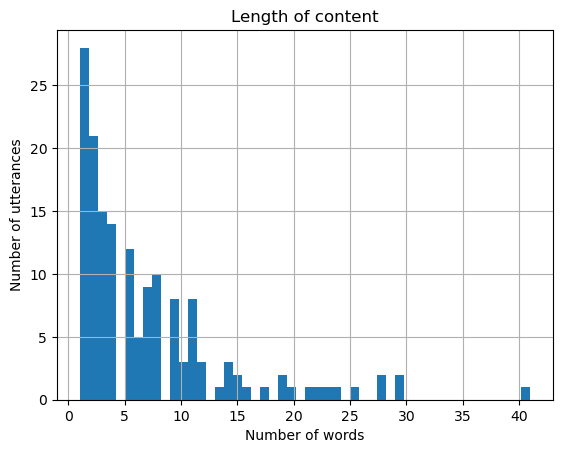

In [1382]:
# See the length of the preprocessed content
df['preprocessed_content'].apply(lambda x: len(x.split())).hist(bins=50)
plt.title("Length of content")
plt.xlabel("Number of words")
plt.ylabel("Number of utterances")
plt.show()

In [1383]:
df = df.groupby(['File Name','turn_index']).agg({ 
    'Content': ' '.join,  # Combine raw text
    'preprocessed_content': ' '.join,  # Combine preprocessed text
    'Experiment': 'first',   # Keep the first 
    'Condition': 'first',   # Keep the first
    'Id': 'first',   # Keep the first
    'Speaker': 'first',   # Keep the first
}).reset_index()
df

,File Name,turn_index,Content,preprocessed_content,Experiment,Condition,Id,Speaker
0,S301final,3,the points i think are like meditating i could...,point meditate gear disturbing completely diss...,Compassion,1,301,Participant
1,S301final,8,"to it was easier, yeah, to my inner self yes b...",easy inner self physical self easy myself,Compassion,1,301,Participant
2,S301final,10,i didn't know this much difference between the...,difference warm feeling chest tube love myself...,Compassion,1,301,Participant
3,S301final,12,i don't know because i felt like it was very d...,differ different relate physical love body wat...,Compassion,1,301,Participant
4,S301final,18,no i think i have already said,say,Compassion,1,301,Participant
...,...,...,...,...,...,...,...,...
91,S313,30,i think it helped it helps you focus because y...,help help focus talk raise hand hand raise help,Compassion,1,313,Participant
92,S313,32,no i didn't even notice,notice,Compassion,1,313,Participant
93,S313,34,i definitely felt like i didn't have a lot of ...,definitely lot sensation float body weight mas...,Compassion,1,313,Participant
94,S313,36,no at my place,place,Compassion,1,313,Participant


In [1384]:
docs = list(df.preprocessed_content)
print(len(docs))

96


In [1385]:
# look rows with a specific word in the column preprocessed_content
df[df['preprocessed_content'].str.contains("course")]

,File Name,turn_index,Content,preprocessed_content,Experiment,Condition,Id,Speaker


# Define the model

In [1386]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-mpnet-base-v2") # all-mpnet-base-v2, all-MiniLM-L6-v2
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


In [1387]:
from umap import UMAP
from hdbscan import HDBSCAN

# Dimensionality reduction model
umap_model = UMAP(n_neighbors=15, n_components=8, min_dist=0.0, metric='cosine', random_state=42)

# Clustering model
hdbscan_model = HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom')

topic_model = BERTopic(                       
# Pipeline models
embedding_model=embedding_model,
umap_model=umap_model,
hdbscan_model=hdbscan_model,
#nr_topics=9,  # Number of topics

# Hyperparameters
verbose=True,)

In [1388]:
topics, ini_probs = topic_model.fit_transform(docs)
num_topics = len(topic_model.get_topics()) - 1
num_topics

2025-01-06 18:37:11,788 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]
2025-01-06 18:37:15,618 - BERTopic - Embedding - Completed ✓
2025-01-06 18:37:15,618 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-06 18:37:15,844 - BERTopic - Dimensionality - Completed ✓
2025-01-06 18:37:15,844 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-06 18:37:15,851 - BERTopic - Cluster - Completed ✓
2025-01-06 18:37:15,857 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-06 18:37:15,877 - BERTopic - Representation - Completed ✓


9

In [1389]:
topic_model.get_topic_info().to_csv("topic_model.csv")
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,20,-1_good_myself_thank_practice,"[good, myself, thank, practice, help, hard, pe...",[practice regularly call compassion regularly ...
1,0,18,0_focus_leg_lot_distract,"[focus, leg, lot, distract, go, head, eye, gue...",[guess make sense able picture find myself foc...
2,1,11,1_send_place_love_happy,"[send, place, love, happy, long, lady, room, d...",[say lift hand lady will lonely raise hand say...
3,2,11,2_see_myself_awake_love,"[see, myself, awake, love, despite, notice, se...","[see cloud see image see move fast, easy see m..."
4,3,9,3_feeling_warmth_warm_compassionate,"[feeling, warmth, warm, compassionate, thought...",[differ different relate physical love body wa...
5,4,9,4_reality_virtual_experiment_sensation,"[reality, virtual, experiment, sensation, soun...",[experiment nice include virtual reality chang...
6,5,6,5_eye_close_open_likewise,"[eye, close, open, likewise, normally, 30, eas...","[eye close, say close close normally close eye..."
7,6,5,6_condition_100_30_70,"[condition, 100, 30, 70, 78, 75, teacher, 80, ...","[help 100 term percentage make 75, condition 7..."
8,7,4,7_easy_fun_nice_imagine,"[easy, fun, nice, imagine, difficult, , , , , ]","[fun, easy nice, easy easy imagine]"
9,8,3,8_self_easy_critical_aspect,"[self, easy, critical, aspect, criticism, figu...","[easy inner self physical self easy myself, pr..."


In [1390]:
# # Reduce outliers with pre-calculate embeddings
# new_topics = topic_model.reduce_outliers(docs, topics, strategy="embeddings", embeddings=embeddings)
# topic_model.update_topics(docs, topics=new_topics)
# topics = new_topics

# # Display new topics
# topic_model.get_topic_info()

In [1391]:
topic_model.visualize_barchart(top_n_topics=16)

In [1392]:
topic_model.visualize_topics()

In [1406]:
#topic_model.visualize_heatmap(n_clusters = num_topics-1)

In [1410]:
df.Id.unique()

array([301, 302, 303, 304, 305, 306, 307, 313])

In [1411]:
topics_per_class = topic_model.topics_per_class(docs, classes=df.Id)
topic_model.visualize_topics_per_class(topics_per_class)

8it [00:00, 60.96it/s]


In [1408]:
topics_per_class

,Topic,Words,Frequency,Class,Name
0,2,"say, see, myself, awake, love",1,301,2_see_myself_awake_love
1,3,"difference, feeling, relate, love, body",2,301,3_feeling_warmth_warm_compassionate
2,4,"relate, room, people, reality, virtual",1,301,4_reality_virtual_experiment_sensation
3,8,"self, inner, physical, easy, myself",1,301,8_self_easy_critical_aspect
4,-1,"thank, help, hand, shoulder, place",4,302,-1_good_myself_thank_practice
5,0,"color, trouser, wear, shirt, different",1,302,0_focus_leg_lot_distract
6,1,"happy, long, lady, place, room",6,302,1_send_place_love_happy
7,2,"see, cloud, appear, fast, move",4,302,2_see_myself_awake_love
8,4,"use, idea, experiment, virtual, reality",1,302,4_reality_virtual_experiment_sensation
9,5,"close, eye, open, likewise, normally",4,302,5_eye_close_open_likewise


In [1395]:
#hierarchical_topics = topic_model.hierarchical_topics(docs)
#topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [1396]:
df['one_topic'] = topics
topic_name_to_id = dict(zip(topic_model.get_topic_info().Topic, topic_model.get_topic_info().Name))
df['one_topic_name'] = df['one_topic'].map(topic_name_to_id)

df.to_csv("df_topic.csv", index = False)

In [1397]:
topic_name_to_id

{-1: '-1_good_myself_thank_practice',
 0: '0_focus_leg_lot_distract',
 1: '1_send_place_love_happy',
 2: '2_see_myself_awake_love',
 3: '3_feeling_warmth_warm_compassionate',
 4: '4_reality_virtual_experiment_sensation',
 5: '5_eye_close_open_likewise',
 6: '6_condition_100_30_70',
 7: '7_easy_fun_nice_imagine',
 8: '8_self_easy_critical_aspect'}

# Topic Distribution (More than one topic per docs) 
- To reduce the numbers of outliers and avoid False Positive (Interesting when looking at one specif topic)

### Look similarities

In [1398]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 

distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_))
dist_df = pd.DataFrame(distance_matrix, columns=topic_model.topic_labels_.values(), 
                       index=topic_model.topic_labels_.values())

tmp = []
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']
    for t2 in rec:
        if t2 == 'index': 
            continue
        tmp.append(
            {
                'topic1': t1, 
                'topic2': t2, 
                'distance': rec[t2]
            }
        )

pair_dist_df = pd.DataFrame(tmp)

pair_dist_df = pair_dist_df[(pair_dist_df.topic1.map(
      lambda x: not x.startswith('-1'))) & 
            (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))]
pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]
pair_dist_df.sort_values('distance', ascending = False).head(20)

,topic1,topic2,distance
15,0_focus_leg_lot_distract,4_reality_virtual_experiment_sensation,0.728350
45,3_feeling_warmth_warm_compassionate,4_reality_virtual_experiment_sensation,0.652427
23,1_send_place_love_happy,2_see_myself_awake_love,0.565539
16,0_focus_leg_lot_distract,5_eye_close_open_likewise,0.544758
35,2_see_myself_awake_love,4_reality_virtual_experiment_sensation,0.543718
14,0_focus_leg_lot_distract,3_feeling_warmth_warm_compassionate,0.539695
39,2_see_myself_awake_love,8_self_easy_critical_aspect,0.502387
13,0_focus_leg_lot_distract,2_see_myself_awake_love,0.493842
34,2_see_myself_awake_love,3_feeling_warmth_warm_compassionate,0.493510
24,1_send_place_love_happy,3_feeling_warmth_warm_compassionate,0.492986


### Multiples topics

In [1399]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(
      docs, window = 5, calculate_tokens=True)

100%|██████████| 1/1 [00:00<00:00, 46.63it/s]


In [1400]:
import tqdm
import plotly.express as px

tmp_dfs = []

# iterating through different threshold levels
for thr in tqdm.tqdm(np.arange(0, 0.35, 0.001)):
    # calculating number of topics with probability > threshold for each document
    tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
        columns = {0: 'num_topics'}
    )
    tmp_df['num_docs'] = 1
    
    tmp_df['num_topics_group'] = tmp_df['num_topics']\
        .map(lambda x: str(x) if x < 5 else '5+')
    
    # aggregating stats
    tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
    tmp_df_aggr['threshold'] = thr
    
    tmp_dfs.append(tmp_df_aggr)

num_topics_stats_df = pd.concat(tmp_dfs).pivot(index = 'threshold', 
                              values = 'num_docs',
                              columns = 'num_topics_group').fillna(0)

num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

# visualisation
colormap = px.colors.sequential.YlGnBu
px.area(num_topics_stats_df, 
       title = 'Distribution of number of topics',
       labels = {'num_topics_group': 'number of topics',
                'value': 'share of reviews, %'},
       color_discrete_map = {
          '0': colormap[0],
          '1': colormap[3],
          '2': colormap[4],
          '3': colormap[5],
          '4': colormap[6],
          '5+': colormap[7]
      })

100%|██████████| 350/350 [00:00<00:00, 391.36it/s]


In [1401]:
threshold = 0.2

# define topic with probability > 0.13 for each document
df['multiple_topics'] = list(map(
    lambda doc_topic_distr: list(map(
        lambda y: y[0], filter(lambda x: x[1] >= threshold, 
                               (enumerate(doc_topic_distr)))
    )), topic_distr
))

# creating a dataset with docid, topic
tmp_data = []

for rec in df.to_dict('records'):
    if len(rec['multiple_topics']) != 0:
        mult_topics = rec['multiple_topics']
    else:
        mult_topics = [-1]
        
    for topic in mult_topics: 
        tmp_data.append(
            {
                'topic': topic,
                'id': rec['Content'],
            }
        )
            
mult_topics_df = pd.DataFrame(tmp_data)
df["multiple_topics_name"] = df["multiple_topics"].map(lambda x: [topic_name_to_id.get(i, "No topic") for i in x])


In [1402]:
df.to_csv("df_topic.csv", index = False)
df.head()

,File Name,turn_index,Content,preprocessed_content,Experiment,Condition,Id,Speaker,one_topic,one_topic_name,multiple_topics,multiple_topics_name
0,S301final,3,the points i think are like meditating i could...,point meditate gear disturbing completely diss...,Compassion,1,301,Participant,4,4_reality_virtual_experiment_sensation,[4],[4_reality_virtual_experiment_sensation]
1,S301final,8,"to it was easier, yeah, to my inner self yes b...",easy inner self physical self easy myself,Compassion,1,301,Participant,8,8_self_easy_critical_aspect,[8],[8_self_easy_critical_aspect]
2,S301final,10,i didn't know this much difference between the...,difference warm feeling chest tube love myself...,Compassion,1,301,Participant,3,3_feeling_warmth_warm_compassionate,"[2, 3]","[2_see_myself_awake_love, 3_feeling_warmth_war..."
3,S301final,12,i don't know because i felt like it was very d...,differ different relate physical love body wat...,Compassion,1,301,Participant,3,3_feeling_warmth_warm_compassionate,[3],[3_feeling_warmth_warm_compassionate]
4,S301final,18,no i think i have already said,say,Compassion,1,301,Participant,2,2_see_myself_awake_love,"[1, 5, 6]","[1_send_place_love_happy, 5_eye_close_open_lik..."


### Look differences btw single and multiple topics

In [1403]:
topic_name_to_id

{-1: '-1_good_myself_thank_practice',
 0: '0_focus_leg_lot_distract',
 1: '1_send_place_love_happy',
 2: '2_see_myself_awake_love',
 3: '3_feeling_warmth_warm_compassionate',
 4: '4_reality_virtual_experiment_sensation',
 5: '5_eye_close_open_likewise',
 6: '6_condition_100_30_70',
 7: '7_easy_fun_nice_imagine',
 8: '8_self_easy_critical_aspect'}

In [1404]:
# look for a specific topic the topic 12
specific_topic = df[df['one_topic'] == 12]
print(len(specific_topic))
# look at specifc columns
specific_topic[['Experiment','Id','Condition','Speaker','Content','multiple_topics_name']]

0


,Experiment,Id,Condition,Speaker,Content,multiple_topics_name


In [1405]:
# look for a specific topic the topic 12
specific_topic = df[df['multiple_topics'].map(lambda x: 12 in x)]
print(len(specific_topic))
# look at specifc columns
specific_topic[['Experiment','Id','Condition','Speaker','Content','multiple_topics_name']]

0


,Experiment,Id,Condition,Speaker,Content,multiple_topics_name
